In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
import numpy as np
import faiss
from torch.utils.data import DataLoader
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [ ]:
# Load CIFAR-100 dataset
def load_cifar100():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # ResNet input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    dataset = datasets.CIFAR100(root="./data", train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=4)
    return dataset, dataloader

In [ ]:
# Load Pretrained ResNet-18 Model
def get_resnet18():
    model = models.resnet18(pretrained=True)
    model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove final FC layer
    model.eval()
    return model

In [ ]:
# Extract Feature Vectors
def extract_features(model, dataloader, device="cuda"):
    model = model.to(device)
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            output = model(images).squeeze(-1).squeeze(-1)
            features.append(output.cpu().numpy())
            labels.append(targets.numpy())
    return np.vstack(features), np.hstack(labels)  # Feature shape: (num_images, feature_dim)

In [ ]:
# Build FAISS Index
def build_faiss_index(features):
    d = features.shape[1]  # Feature dimension
    index = faiss.IndexFlatL2(d)  # L2 distance-based index
    index.add(features)  # Add dataset features to the index
    return index

In [ ]:
# Build Hashing Index
def build_hashing_index(features):
    features = normalize(features, axis=1)  # Normalize for cosine similarity
    nn = NearestNeighbors(n_neighbors=5, metric='cosine')
    nn.fit(features)
    return nn

In [ ]:
# Retrieve Images Using FAISS
def retrieve_similar_images_faiss(query_features, index, k=5):
    distances, indices = index.search(query_features, k)  # Retrieve top-k matches
    return indices, distances


In [ ]:
# Retrieve Images Using Hashing
def retrieve_similar_images_hashing(query_features, nn, k=5):
    query_features = normalize(query_features, axis=1)
    distances, indices = nn.kneighbors(query_features, n_neighbors=k)
    return indices, distances

In [ ]:
# Retrieve Images Using Combined FAISS + LSH Approach
def retrieve_combined_images(query_features, faiss_index, hashing_index, k=5):
    # Get top-k indices from FAISS
    faiss_indices, _ = retrieve_similar_images_faiss(query_features, faiss_index, k=k)
    # Get top-k indices from LSH
    hashing_indices, _ = retrieve_similar_images_hashing(query_features, hashing_index, k=k)
    # Merge results: prioritize images appearing in both FAISS & LSH
    combined_indices = []
    for i in range(len(faiss_indices)):
        combined_set = list(set(faiss_indices[i]) | set(hashing_indices[i]))  # Merge both sets
        combined_indices.append(combined_set[:k])  # Take top-k

    return np.array(combined_indices)

In [ ]:
# Visualize Retrieved Images
def visualize_retrieval(query_idx, dataset, model, faiss_index, hashing_index, device, k=5):
    query_image, query_label = dataset[query_idx]
    query_image_input = query_image.unsqueeze(0).to(device)

    # Extract features for query image
    with torch.no_grad():
        query_features = model(query_image_input).cpu().numpy().reshape(1, -1)
    # Retrieve similar images
    faiss_indices, _ = retrieve_similar_images_faiss(query_features, faiss_index, k)
    hashing_indices, _ = retrieve_similar_images_hashing(query_features, hashing_index, k)
    combined_indices = retrieve_combined_images(query_features, faiss_index, hashing_index, k)

    fig, axes = plt.subplots(4, k, figsize=(15, 6))

    # Show query image
    axes[0, 0].imshow(query_image.permute(1, 2, 0))
    axes[0, 0].set_title(f"Query (Label: {query_label})")
    axes[0, 0].axis("off")

    retrieval_methods = [("FAISS", faiss_indices), ("LSH", hashing_indices), ("Combined", combined_indices)]

    for row, (method, indices) in enumerate(retrieval_methods, start=1):
        for col, img_idx in enumerate(indices[0]):
            retrieved_image, retrieved_label = dataset[img_idx]
            axes[row, col].imshow(retrieved_image.permute(1, 2, 0))
            axes[row, col].set_title(f"{method} - {retrieved_label}")
            axes[row, col].axis("off")

    plt.show()


Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

Query Image Index: 41074


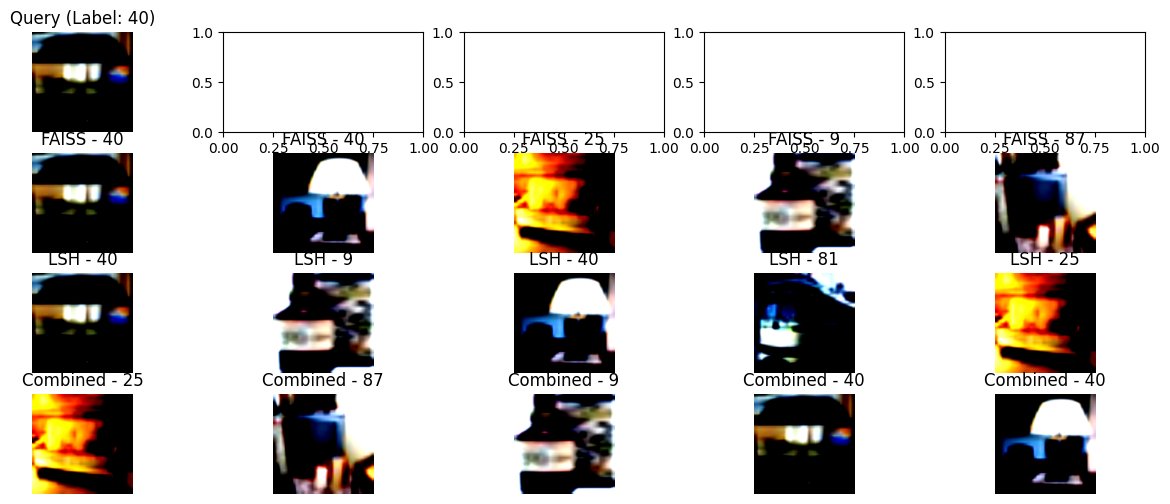

In [ ]:
# Main Execution
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load dataset and model
    dataset, dataloader = load_cifar100()
    model = get_resnet18()

    # Extract features and build indices
    features, labels = extract_features(model, dataloader, device)
    faiss_index = build_faiss_index(features)
    hashing_index = build_hashing_index(features)

    # Select a random query image
    query_idx = np.random.randint(len(dataset))
    print(f"Query Image Index: {query_idx}")

    # Visualize retrieval results
    visualize_retrieval(query_idx, dataset, model, faiss_index, hashing_index, device, k=5)

In [ ]:
def compute_precision(query_idx, dataset, labels, model, faiss_index, hashing_index, device, k=5):
    """Compute precision for image retrieval using FAISS, LSH, and Combined methods."""
    query_image, query_label = dataset[query_idx]
    query_image_input = query_image.unsqueeze(0).to(device)

    # Extract query image features
    with torch.no_grad():
        query_features = model(query_image_input).cpu().numpy().reshape(1, -1)

    # Retrieve top-k similar images
    faiss_indices, _ = retrieve_similar_images_faiss(query_features, faiss_index, k)
    hashing_indices, _ = retrieve_similar_images_hashing(query_features, hashing_index, k)
    combined_indices = retrieve_combined_images(query_features, faiss_index, hashing_index, k)

    # Compute precision for each retrieval method
    def calculate_precision(retrieved_indices):
        retrieved_labels = labels[retrieved_indices[0]]  # Labels of retrieved images
        relevant_count = np.sum(retrieved_labels == query_label)  # Count relevant images
        return relevant_count / k  # Precision = relevant / total retrieved

    faiss_precision = calculate_precision(faiss_indices)
    hashing_precision = calculate_precision(hashing_indices)
    combined_precision = calculate_precision(combined_indices)

    print(f"Query Image Label: {query_label}")
    print(f"FAISS Precision: {faiss_precision:.2f}")
    print(f"LSH Precision: {hashing_precision:.2f}")
    print(f"Combined FAISS + LSH Precision: {combined_precision:.2f}")

    return faiss_precision, hashing_precision, combined_precision


# Run Precision Calculation
if __name__ == "__main__":
    query_idx = np.random.randint(len(dataset))
    print(f"\nEvaluating Retrieval for Query Image Index: {query_idx}")
    compute_precision(query_idx, dataset, labels, model, faiss_index, hashing_index, device, k=5)



Evaluating Retrieval for Query Image Index: 12041
Query Image Label: 38
FAISS Precision: 0.80
LSH Precision: 1.00
Combined FAISS + LSH Precision: 0.80
